## Setup

In [1]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tqdm
import os
import scipy.io.wavfile as wav
from time import process_time

from src.ftm import constants as FTM_constants
from src.ftm import rectangular_drum
from src.knn import Knn
from src.phi import JTFS_forward
from src.dataset_utils import theta_ds_create

device = "cuda" if torch.cuda.is_available() else "cpu"

## KNN computation

In [2]:
# Only run this to recreate the parameters CSV, use the dataset in precomputed_S if you want to use the Bruteforce method

#DatasetPath = "data/default_parameters.csv"
#bounds = [['omega', 'tau', 'p', 'd', 'alpha'],[(2.4, 3.8),(0.4, 3),(-5, -0.7),(-5, -0.5),(10e-05, 1)]]
#theta_ds_create(bounds=bounds, subdiv=10, path='data/default_parameters.csv')


# Setting the parameters
DatasetPath = "data/precompute_S/param_dataset.csv"
S_DatasetPath = "data/precompute_S/S_dataset_full.parquet"
parameters_name = ["omega","tau","p","d","alpha"]
logscale = True

# Reading the dataset
DF = torch.from_numpy(pd.read_csv(DatasetPath).to_numpy()).to(device).to(torch.float)

# KNN Params
k = 200
i_r = 85918 #5

# Main job
print('computing the KNN with P-loss...')
t = process_time()
T_knn_ploss = Knn(DF,i_r,k,JTFS_forward,logscale,'P-loss',S_DatasetPath)
print(process_time() - t)

print('computing the KNN with PNP...')
t = process_time()
T_knn_PNP = Knn(DF,i_r,k,JTFS_forward,logscale,'PNP',S_DatasetPath)
print(process_time() - t)

print('computing the KNN with Bruteforce...')
t = process_time()
T_knn_bruteforce = Knn(DF,i_r,k,JTFS_forward,logscale,'Bruteforce',S_DatasetPath)
print(process_time() - t)

computing the KNN with P-loss...
0.0625
computing the KNN with PNP...
5.9375
computing the KNN with Bruteforce...


Bruteforcing in batch: 100%|██████████| 100/100 [04:36<00:00,  2.76s/it]


761.578125


# Methods characterization and comparaison

100%|██████████| 199/199 [14:49<00:00,  4.47s/it]


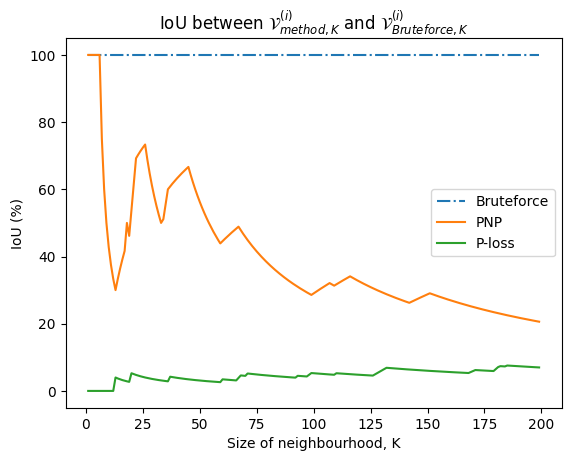

In [3]:
#%%script echo skipping

# Intersection over Union

def row_in_M(r,M):
    for rr in M:
        if (rr==r).all():
            return True
    return False

def card_intersection_of_rows(A,B):
    C = 0
    for r in A:
        C+= int(row_in_M(r,B))
    return C

def card_union_of_rows(A,B):
    return B.size(dim=0) + A.size(dim=0) - card_intersection_of_rows(A,B)

I_BF,U_BF = np.array([]),np.array([])
I_PNP,U_PNP = np.array([]),np.array([])
I_PL,U_PL = np.array([]),np.array([])

for klim in tqdm.tqdm(range(2,k+1)):

    I_BF = np.append(I_BF,card_intersection_of_rows(T_knn_bruteforce[1:klim,:],T_knn_bruteforce[1:klim,:]))
    U_BF = np.append(U_BF,card_union_of_rows(T_knn_bruteforce[1:klim,:],T_knn_bruteforce[1:klim,:]))

    I_PNP = np.append(I_PNP,card_intersection_of_rows(T_knn_PNP[1:klim,:],T_knn_bruteforce[1:klim,:]))
    U_PNP = np.append(U_PNP,card_union_of_rows(T_knn_PNP[1:klim,:],T_knn_bruteforce[1:klim,:]))

    I_PL = np.append(I_PL,card_intersection_of_rows(T_knn_ploss[1:klim,:],T_knn_bruteforce[1:klim,:]))
    U_PL = np.append(U_PL,card_union_of_rows(T_knn_ploss[1:klim,:],T_knn_bruteforce[1:klim,:]))

IoU_BF = I_BF/U_BF
IoU_PNP = I_PNP/U_PNP
IoU_PL = I_PL/U_PL

l = 200
x = np.linspace(1,k-1,k-1)

plt.figure(0)
plt.plot(x[0:l],IoU_BF[0:l]*100,'-.',x[0:l],IoU_PNP[0:l]*100,'-',x[0:l],IoU_PL[0:l]*100,'-')
plt.xlabel("Size of neighbourhood, K")
plt.ylabel("IoU (%)")
plt.legend(['Bruteforce','PNP','P-loss'])
plt.title(r'IoU between $\mathcal{V}_{method,K}^{(i)}$ and $\mathcal{V}_{Bruteforce,K}^{(i)}$')
plt.show()

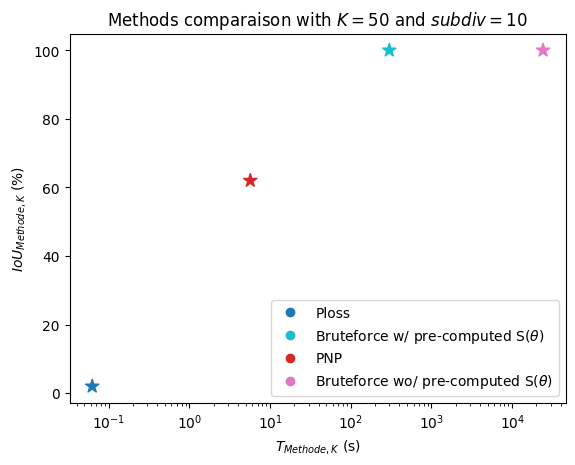

In [4]:
#%%script echo skipping

# Ploss : 0.0625s 2%
# PNP : 5.6875s 62%
# BF (avec) : 300s 100%
# BF (sans) : 24167s 100%

x = [0.0625,5.6875,24167,300]
y = [2,62,100,100]
colors = [0, 1, 2, 3]
labels = [r'Ploss',r'PNP',r'Bruteforce wo/ pre-computed S($\theta$)',r'Bruteforce w/ pre-computed S($\theta$)']
clset = set(zip(colors, labels))

fig = plt.figure(0)
ax = plt.gca()

sc = plt.scatter(x,y,s=100,marker='*',c=colors, cmap="tab10")

ax.set_xscale('log')

handles = [plt.plot([],color=sc.get_cmap()(sc.norm(c)),ls="", marker="o")[0] for c,l in clset ]
labels = [l for c,l in clset]
ax.legend(handles, labels, loc='lower right')

plt.title(r'Methods comparaison with $K=50$ and $subdiv=10$')
plt.xlabel(r'$T_{Methode,K}$ (s)')
plt.ylabel(r'$IoU_{Methode,K}$ (%)')

plt.show()

# Audio exemples

In [5]:
def g(theta):
    return rectangular_drum(theta,logscale,**FTM_constants)

fs = 44300

k_lim = 10

folders = ['bruteforce','pnp','ploss']
neighbourhoods = [T_knn_bruteforce,T_knn_PNP,T_knn_ploss]

for m in range(3):

    folder = folders[m]
    neighbourhood = neighbourhoods[m]

    print('saving for '+folder+" method...")

    for i in tqdm.tqdm(range(min(neighbourhood.size(dim=0),k_lim+1))):

        theta = neighbourhood[i,:]
        sound  = g(theta).cpu().detach().numpy()
        path = 'results/audio/'+str(i_r)+'/'+folder+'/'

        if not os.path.exists(path): os.makedirs(path)

        wav.write(path+str(i)+'.wav',fs,sound)

saving for bruteforce method...


100%|██████████| 11/11 [00:00<00:00, 78.31it/s]


saving for pnp method...


100%|██████████| 11/11 [00:00<00:00, 89.22it/s]


saving for ploss method...


100%|██████████| 11/11 [00:00<00:00, 94.16it/s]
